# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [5]:
#Ejemplo de optimizacion bayesiana, univariada

#limpio la memoria
rm( list=ls() )  #remove all objects
gc()             #garbage collection

require("data.table")
#paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width=20, repr.plot.height=10)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,638424,34.1,1295994,69.3,1295994,69.3
Vcells,1151091,8.8,8388608,64.0,1632313,12.5


Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Loading required package: checkmate


Attaching package: 'checkmate'


The following object is masked from 'package:DiceKriging':

    checkNames




### Defino la funcion a optimizar, un polinomio de grado 4

In [6]:
func_univariada01  <- function( x )
{
  y  <- -2 * (x+13) * (x-3) * (x-7) * (x-19)

  return( y )
}

Grafico la funcion

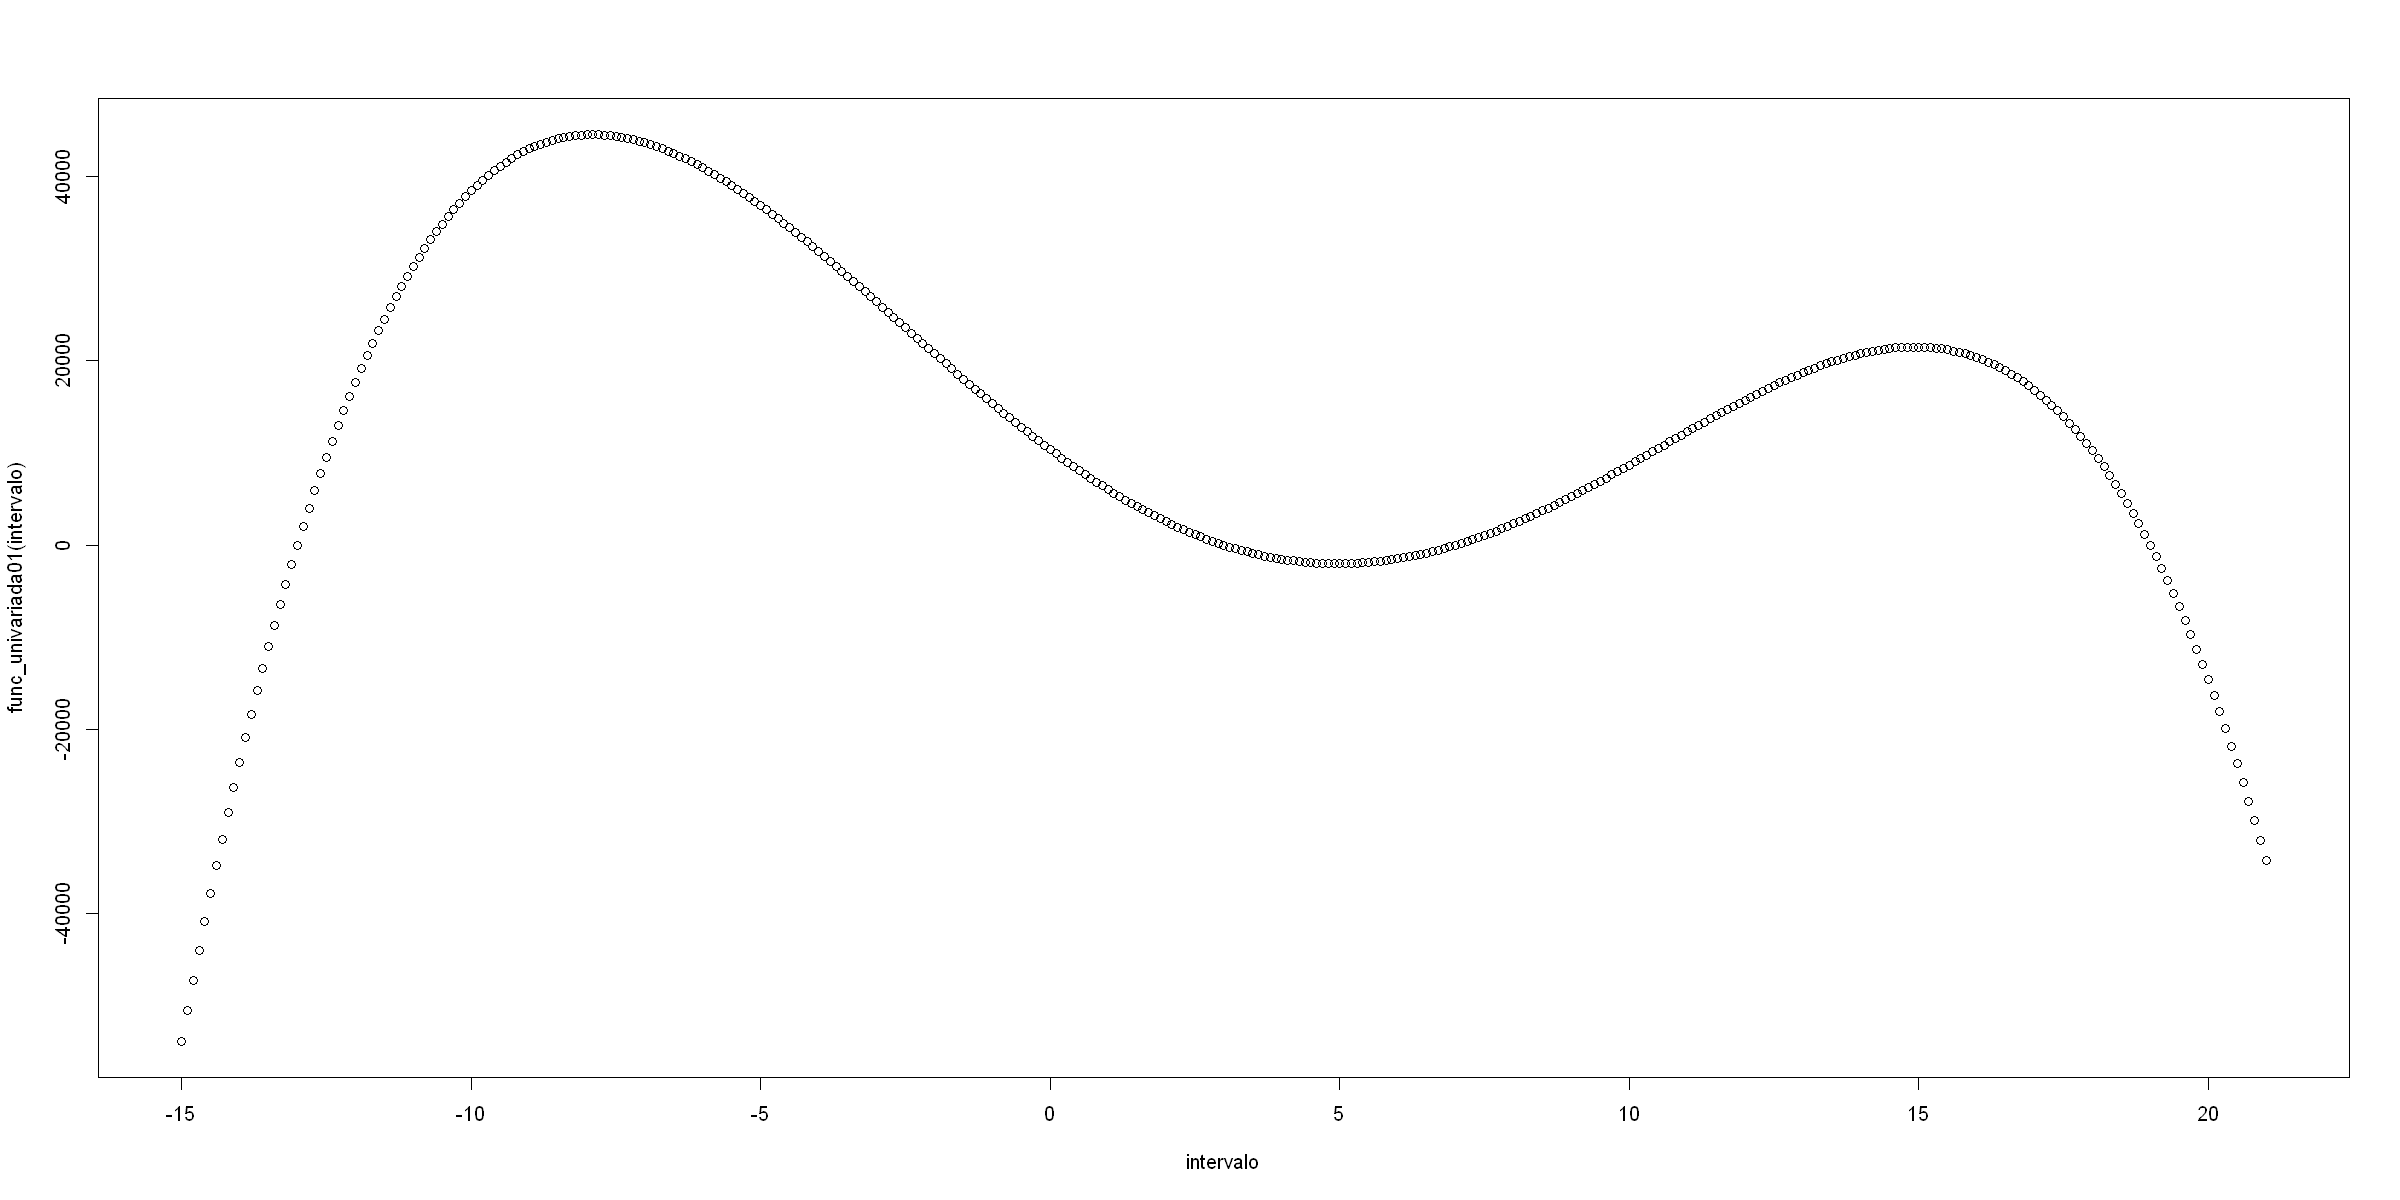

In [7]:
intervalo  <- seq(-15,21,0.1)
plot(intervalo, func_univariada01(intervalo))

La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [8]:
obj.fun  <- makeSingleObjectiveFunction(
              fn=       func_univariada01,
              minimize= FALSE,   #estoy Maximizando la ganancia
              par.set=  makeParamSet(  makeNumericParam( "x", lower= -100, upper=  100) ),
             )

ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [9]:
fproxy  <- makeLearner( cl= "regr.km",
                        predict.type= "se", 
                        covtype= "matern3_2" )

ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [10]:
ctrl  <- makeMBOControl()
ctrl  <- setMBOControlInfill( ctrl, crit= makeMBOInfillCritEI())
ctrl  <- setMBOControlTermination( ctrl, iters= 25 )

finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [11]:
run  <- mbo( fun=      obj.fun, 
             learner= fproxy, 
             control= ctrl )

Computing y column(s) for design. Not provided.

[mbo] 0: x=19.9 : y = -1.23e+04 : 0.0 secs : initdesign

[mbo] 0: x=-31.1 : y = -2.36e+06 : 0.0 secs : initdesign

[mbo] 0: x=83.8 : y = -7.77e+07 : 0.0 secs : initdesign

[mbo] 0: x=-52.3 : y = -1.84e+07 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -74.40001 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=         74.4  |proj g|=     0.002969
At iterate     1  f =         74.4  |proj g|=     0.0029675
At iterate     2  f =       74.391  |proj g|=     0.0002734
At iterate     3  f =       74.391  |proj g|=    3.0615e-05
At iterate     4  f =       74.391  |proj g|=    3.9402e-07
At iterate     5  f =       74.391  |proj g|=    5.8086e-10

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 5.80865e-10
final function

[mbo] 1: x=-2.9 : y = 2.58e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -91.75778 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       91.758  |proj g|=    0.0011181
At iterate     1  f =       91.758  |proj g|=     0.0011175
At iterate     2  f =       91.757  |proj g|=     6.079e-05
At iterate     3  f =       91.756  |proj g|=     3.555e-06
At iterate     4  f =       91.756  |proj g|=    1.2263e-08

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.22627e-08
final function value 91.7565

F = 91.7565
final  value 91.756498 
converge

[mbo] 2: x=10.1 : y = 9.03e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -107.7936 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       107.79  |proj g|=    0.0014047
At iterate     1  f =       107.79  |proj g|=     0.0014044
At iterate     2  f =       107.79  |proj g|=    0.00023204
At iterate     3  f =       107.79  |proj g|=    3.0917e-05
At iterate     4  f =       107.79  |proj g|=    5.8072e-07
At iterate     5  f =       107.79  |proj g|=    1.4892e-09

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.48922e-09
final function

[mbo] 3: x=-16.8 : y = -1.26e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -123.6749 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       123.67  |proj g|=    0.0010451
At iterate     1  f =       123.67  |proj g|=     0.0010449
At iterate     2  f =       123.67  |proj g|=    9.1747e-05
At iterate     3  f =       123.67  |proj g|=    8.9794e-06
At iterate     4  f =       123.67  |proj g|=    8.7834e-08

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 8.78336e-08
final function value 123.672

F = 123.672
final  value 123.671935 
converg

[mbo] 4: x=15.6 : y = 2.11e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -138.0782 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       138.08  |proj g|=   0.00044552
At iterate     1  f =       138.08  |proj g|=    0.00044547

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000445474
final function value 138.078

F = 138.078
final  value 138.078163 
converged


[mbo] 5: x=-9.57 : y = 4.08e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -152.6244 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       152.62  |proj g|=   7.3846e-05
At iterate     1  f =       152.62  |proj g|=    7.3841e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 7.38406e-05
final function value 152.624

F = 152.624
final  value 152.624433 
converged


[mbo] 6: x=3.56 : y = -989 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -166.8414 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       166.84  |proj g|=   0.00015852
At iterate     1  f =       166.84  |proj g|=    0.00015851

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000158508
final function value 166.841

F = 166.841
final  value 166.841428 
converged


[mbo] 7: x=-22.1 : y = -5.49e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -181.155 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       181.16  |proj g|=   0.00036742
At iterate     1  f =       181.16  |proj g|=     0.0003674

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000367402
final function value 181.155

F = 181.155
final  value 181.155036 
converged


[mbo] 8: x=-6.33 : y = 4.2e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -194.3298 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       194.33  |proj g|=   2.2011e-05
At iterate     1  f =       194.33  |proj g|=     2.201e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 2.20101e-05
final function value 194.33

F = 194.33
final  value 194.329794 
converged


[mbo] 9: x=-12.7 : y = 5.54e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -207.4991 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        207.5  |proj g|=    0.0024993
At iterate     1  f =        207.5  |proj g|=     0.0024991
At iterate     2  f =       207.44  |proj g|=    0.00063345
At iterate     3  f =       207.44  |proj g|=     0.0002121
At iterate     4  f =       207.44  |proj g|=             0

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 207.437

F = 207.437
final  value 207.437021 
converged


[mbo] 10: x=17.9 : y = 1.12e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -220.2275 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       220.23  |proj g|=    0.0042541
At iterate     1  f =       220.23  |proj g|=     0.0042538
At iterate     2  f =        220.1  |proj g|=     0.0013093
At iterate     3  f =       220.09  |proj g|=             0

iterations 3
function evaluations 4
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 220.087

F = 220.087
final  value 220.086687 
converged


[mbo] 11: x=0.293 : y = 9.03e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -233.0347 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       233.03  |proj g|=    0.0021032
At iterate     1  f =       233.03  |proj g|=     0.0021031
At iterate     2  f =       233.02  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 233.016

F = 233.016
final  value 233.015789 
converged


[mbo] 12: x=6.95 : y = -95.1 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -245.9529 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       245.95  |proj g|=    0.0032577
At iterate     1  f =       245.95  |proj g|=     0.0032575
At iterate     2  f =       245.91  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 245.908

F = 245.908
final  value 245.907687 
converged


[mbo] 13: x=12.9 : y = 1.85e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -258.5463 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       258.55  |proj g|=    0.0043623
At iterate     1  f =       258.55  |proj g|=     0.0043621
At iterate     2  f =       258.47  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 258.473

F = 258.473
final  value 258.472956 
converged


[mbo] 14: x=-7.94 : y = 4.46e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -270.3689 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       270.37  |proj g|=    0.0044885
At iterate     1  f =       270.37  |proj g|=     0.0044882
At iterate     2  f =       270.33  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 270.334

F = 270.334
final  value 270.334414 
converged


[mbo] 15: x=-4.68 : y = 3.54e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -282.2227 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       282.22  |proj g|=    0.0054122
At iterate     1  f =       282.22  |proj g|=     0.0054119
At iterate     2  f =       282.17  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 282.174

F = 282.174
final  value 282.174078 
converged


[mbo] 16: x=-11 : y = 3.05e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -294.1082 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       294.11  |proj g|=    0.0084724
At iterate     1  f =       294.11  |proj g|=     0.0084715
At iterate     2  f =       293.87  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 293.874

F = 293.874
final  value 293.873540 
converged


[mbo] 17: x=-1.36 : y = 1.73e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -305.6235 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       305.62  |proj g|=    0.0068956
At iterate     1  f =       305.62  |proj g|=      0.006895
At iterate     2  f =       305.58  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 305.575

F = 305.575
final  value 305.575001 
converged


[mbo] 18: x=-7.17 : y = 4.4e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -316.3234 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       316.32  |proj g|=    0.0075268
At iterate     1  f =       316.32  |proj g|=     0.0075262
At iterate     2  f =       316.29  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 316.286

F = 316.286
final  value 316.285601 
converged


[mbo] 19: x=14.3 : y = 2.12e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -327.9225 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       327.92  |proj g|=    0.0099896
At iterate     1  f =       327.92  |proj g|=     0.0099885
At iterate     2  f =       327.73  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 327.731

F = 327.731
final  value 327.731095 
converged


[mbo] 20: x=-8.73 : y = 4.37e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -338.4773 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       338.48  |proj g|=     0.010198
At iterate     1  f =       338.48  |proj g|=      0.010197
At iterate     2  f =       338.33  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 338.333

F = 338.333
final  value 338.332584 
converged


[mbo] 21: x=5.26 : y = -1.97e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -350.1446 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       350.14  |proj g|=      0.01017
At iterate     1  f =       350.14  |proj g|=      0.010169
At iterate     2  f =       350.07  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 350.073

F = 350.073
final  value 350.072753 
converged


[mbo] 22: x=-5.55 : y = 3.93e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -360.7949 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       360.79  |proj g|=     0.011559
At iterate     1  f =       360.79  |proj g|=      0.011557
At iterate     2  f =       360.66  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 360.662

F = 360.662
final  value 360.661669 
converged


[mbo] 23: x=11.5 : y = 1.41e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -372.1441 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       372.14  |proj g|=     0.011959
At iterate     1  f =       372.14  |proj g|=      0.011957
At iterate     2  f =       372.05  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 372.046

F = 372.046
final  value 372.045538 
converged


[mbo] 24: x=1.87 : y = 2.95e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -383.9609 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       383.96  |proj g|=     0.015608
At iterate     1  f =       383.96  |proj g|=      0.015605
At iterate     2  f =       383.58  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 383.577

F = 383.577
final  value 383.577448 
converged


[mbo] 25: x=8.56 : y = 3.91e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  272.201 
  - best initial criterion value(s) :  -395.1197 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       395.12  |proj g|=     0.013413
At iterate     1  f =       395.12  |proj g|=      0.013411
At iterate     2  f =       395.03  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 395.028

F = 395.028
final  value 395.027862 
converged


In [12]:
tb_resultados  <- as.data.table( run$opt.path )

In [13]:
tb_resultados

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
19.8608962,-1.226908e+04,0,NA,NA,0.01,NA,NA,NA,initdesign,NA,NA,NA
-31.1071961,-2.358492e+06,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
83.7589685,-7.768569e+07,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
-52.3415338,-1.843460e+07,0,NA,NA,0.00,NA,NA,NA,initdesign,NA,NA,NA
-2.8964424,2.581945e+04,1,NA,NA,0.00,-8820117.384,NA,0.09,infill_ei,0.24,14512175.14,5285758.1180
10.0956662,9.034606e+03,2,NA,NA,0.00,-2462665.828,NA,0.05,infill_ei,0.25,3913720.72,1584139.6388
-16.7565349,-1.260860e+05,3,NA,NA,0.00,-1742145.960,NA,0.03,infill_ei,0.47,3398149.20,739245.3361
15.6158418,2.105238e+04,4,NA,NA,0.00,-460060.230,NA,0.03,infill_ei,0.29,693085.12,337830.1144
-9.5721213,4.081169e+04,5,NA,NA,0.00,-324731.726,NA,0.05,infill_ei,0.28,872707.60,-22085.8334


In [14]:
tb_resultados[ which.max( tb_resultados$y ) ]

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-7.944016,44559.68,14,NA,NA,0,-24240.65,NA,0.03,infill_ei,0.28,57350.8,44685.72


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?